<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h1>
<hr style=" border:none; height:3px;">
<center>Projet Machine Learning - Potabilité de l'eau</center>
<hr style=" border:none; height:3px;">
</h1>

###### @Maxime_Zennaro @Rayan_Smaoui @Wallerand_Peugeot

## 1. Imports

In [13]:
#Basic libraries
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

#sklearn functions to facilitate models evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#sklearn classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#sklearn imputation modules
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 2. Data exploration

In [3]:
path = "data/"
drinking_water_potability = pd.read_csv(path + "drinking_water_potability.csv")

In [5]:
drinking_water_potability.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
drinking_water_potability.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


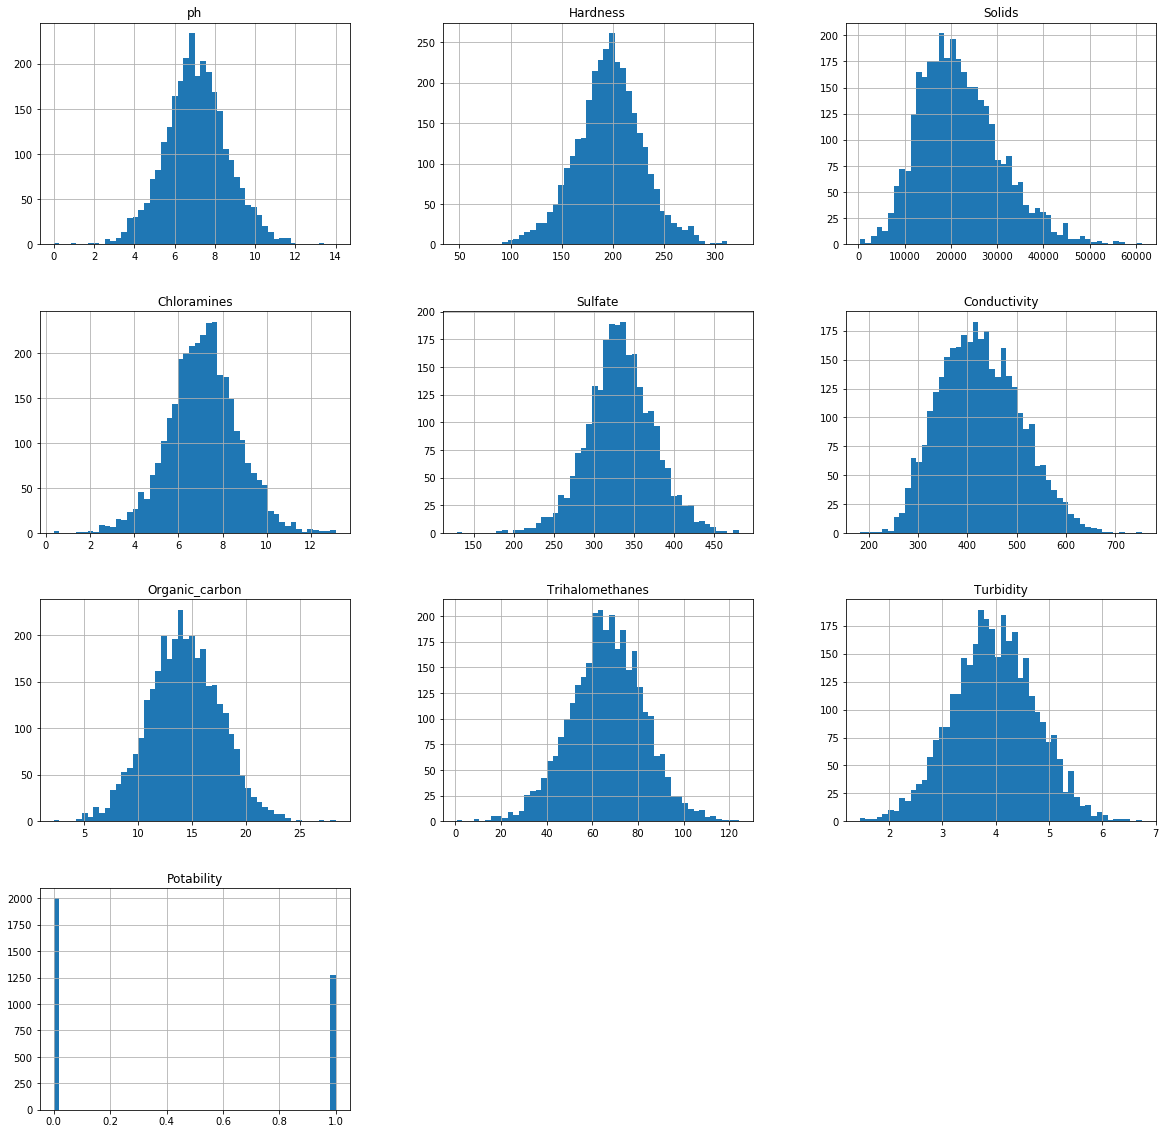

In [7]:
drinking_water_potability.hist(bins = 50, figsize = (20,20))
plt.show()

In [8]:
#Checking missing values
missing_df = drinking_water_potability.isna()
missing_df = np.round(100 * missing_df.sum()/len(drinking_water_potability), 2)
missing_df

ph                 14.99
Hardness            0.00
Solids              0.00
Chloramines         0.00
Sulfate            23.84
Conductivity        0.00
Organic_carbon      0.00
Trihalomethanes     4.95
Turbidity           0.00
Potability          0.00
dtype: float64

In [4]:
#Checking correlation with Potability
corr_matrix = drinking_water_potability.corr()
corr_matrix["Potability"].sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64

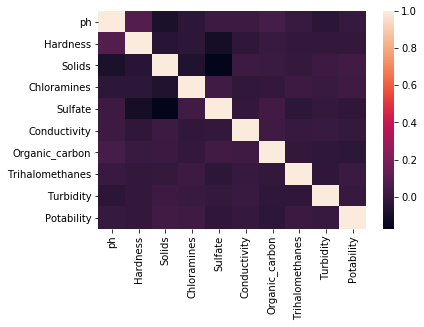

In [202]:
#Checking correlation matrix
sns.heatmap(drinking_water_potability.corr())

In [6]:
#Creating a scaled dataframe
df_scaled = drinking_water_potability.copy()
for col in df_scaled.columns :
    if col != 'Potability' :
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = df_scaled[col].apply(lambda x : (x-mean)/std)
    else :
        df_scaled[col] = df_scaled[col].apply(lambda x : str(x))

df_scaled.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2.785000e+03,3.276000e+03,3.276000e+03,3.276000e+03,2.495000e+03,3.276000e+03,3.276000e+03,3.114000e+03,3.276000e+03
mean,1.060709e-14,5.015194e-16,2.483870e-15,-2.055497e-15,-1.773246e-14,-6.164788e-15,1.521134e-15,1.380613e-15,-4.304927e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.441264e+00,-4.529762e+00,-2.473966e+00,-4.276635e+00,-4.944264e+00,-3.027828e+00,-3.653077e+00,-4.059243e+00,-3.225068e+00
25%,-6.195136e-01,-5.936466e-01,-7.238810e-01,-6.284287e-01,-6.296057e-01,-7.481769e-01,-6.708163e-01,-6.523494e-01,-6.754064e-01
50%,-2.762458e-02,1.819146e-02,-1.238810e-01,5.067436e-03,-1.695520e-02,-5.345119e-02,-2.014179e-02,1.398405e-02,-1.506775e-02
75%,6.154799e-01,6.173390e-01,6.065606e-01,6.270101e-01,6.319747e-01,6.877555e-01,6.869921e-01,6.764250e-01,6.836823e-01
max,4.339911e+00,3.855092e+00,4.472006e+00,3.793052e+00,3.555435e+00,4.047526e+00,4.236500e+00,3.561278e+00,3.552379e+00


In [21]:
df_scaled.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1959,-0.208229,-0.911764,0.052574,1.120057,-0.390069,1.252777,-0.443056,-0.671408,-0.838401,1
848,0.928562,0.273644,-0.607600,0.655064,NaN,-0.969565,1.392969,0.104703,-1.477350,0
34,NaN,1.092190,-0.824181,-1.040602,NaN,-0.522411,-0.640245,1.216966,1.361359,0
810,-3.820365,-1.920712,-0.580624,1.371381,2.670410,-1.285680,-1.165268,-1.410684,1.529785,1
525,-0.114440,-0.272331,-0.340946,-0.130888,NaN,0.031944,-0.515334,-1.361117,1.799756,0


## 3. Basic models without data imputation

### 3.1 Logistic Regression + deleting columns with missing values

In [19]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))

----- Logistic Regresion -----
Accuracy : 60.99 %
Precision : 30.49 %
Rappel : 50.0 %


### 3.2 Decision Tree + deleting columns with missing values

In [20]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))

----- Decision Tree -----
Accuracy : 53.17 %
Precision : 50.98 %
Rappel : 50.86 %


### 3.3 KNN + deleting columns with missing values

In [21]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = KNeighborsClassifier()

score_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN_d,2)))
print('Precision : {} %'.format(np.round(precision_KNN_d,2)))
print('Rappel : {} %'.format(np.round(recall_KNN_d,2)))

----- KNN -----
Accuracy : 56.96 %
Precision : 52.62 %
Rappel : 52.18 %


## 4. Basic Models with different imputations

### 4.1 Mean Imputation

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 61.02 %
Precision : 45.51 %
Rappel : 50.07 %
----- Decision Tree -----
Accuracy : 57.97 %
Precision : 55.53 %
Rappel : 54.66 %
----- KNN -----
Accuracy : 59.31 %
Precision : 55.67 %
Rappel : 54.89 %


### 4.2 KNN Imputation

In [16]:
imputer = KNNImputer(n_neighbors=5)

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 60.99 %
Precision : 44.79 %
Rappel : 50.06 %
----- Decision Tree -----
Accuracy : 56.29 %
Precision : 53.41 %
Rappel : 53.22 %
----- KNN -----
Accuracy : 59.03 %
Precision : 55.19 %
Rappel : 54.39 %


### 4.3 Iterative Imputation

In [38]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 61.02 %
Precision : 45.51 %
Rappel : 50.07 %
----- Decision Tree -----
Accuracy : 56.72 %
Precision : 54.19 %
Rappel : 54.17 %
----- KNN -----
Accuracy : 59.52 %
Precision : 55.82 %
Rappel : 55.05 %


## 5. Stratigying to balance data

In [18]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

#Stratifying is done here
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN_d,2)))
print('Precision : {} %'.format(np.round(precision_KNN_d,2)))
print('Rappel : {} %'.format(np.round(recall_KNN_d,2)))

----- Logistic Regresion -----
Accuracy : 61.08 %
Precision : 40.53 %
Rappel : 50.13 %
----- Decision Tree -----
Accuracy : 58.82 %
Precision : 57.76 %
Rappel : 56.74 %
----- KNN -----
Accuracy : 62.76 %
Precision : 59.82 %
Rappel : 58.16 %


## 6. More advanced models

### 6.1 Random Forest

In [22]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = RandomForestClassifier()

accuracy_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_RF,2)))
print('Precision : {} %'.format(np.round(precision_RF,2)))
print('Rappel : {} %'.format(np.round(recall_RF,2)))

----- Random Forest -----
Accuracy : 66.91 %
Precision : 65.9 %
Rappel : 61.44 %


### 6.2 Support Vector Classification

In [23]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = SVC()

accuracy_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- SVM -----')
print('Accuracy : {} %'.format(np.round(accuracy_SVM,2)))
print('Precision : {} %'.format(np.round(precision_SVM,2)))
print('Rappel : {} %'.format(np.round(recall_SVM,2)))

----- SVM -----
Accuracy : 67.92 %
Precision : 69.79 %
Rappel : 60.85 %


### 6.3 Gaussian Process Classification

In [24]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = GaussianProcessClassifier()

accuracy_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_GC,2)))
print('Precision : {} %'.format(np.round(precision_GC,2)))
print('Rappel : {} %'.format(np.round(recall_GC,2)))

----- Random Forest -----
Accuracy : 66.67 %
Precision : 65.87 %
Rappel : 60.63 %


### 6.4 Multi Layer Perceptron Classification

In [25]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = MLPClassifier()

accuracy_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_MLP,2)))
print('Precision : {} %'.format(np.round(precision_MLP,2)))
print('Rappel : {} %'.format(np.round(recall_MLP,2)))

----- Random Forest -----
Accuracy : 67.31 %
Precision : 66.21 %
Rappel : 62.32 %


## 7. Parameters Optimisation : Grid Search

### 7.1 Random Forest Grid search

In [57]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = RandomForestClassifier()
parameters = {'n_estimators':[50,100, 200], 'criterion':['gini', 'entropy'], 'max_depth' : [None,5,10], 'max_features' : ['auto', 'log2']}
clf = GridSearchCV(clf2, parameters, n_jobs = -1)
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.6788766788766789


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.403331,0.201809,0.040560,0.008738,gini,None,auto,200,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.674797,0.660569,0.661914,0.670061,0.676171,0.668702,0.006434,1
17,0.989055,0.029589,0.029329,0.000742,gini,10,log2,200,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.666667,0.656504,0.670061,0.674134,0.670061,0.667485,0.005979,2
20,2.207438,0.105643,0.034436,0.002400,entropy,None,auto,200,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.680894,0.630081,0.674134,0.676171,0.674134,0.667083,0.018665,3
5,1.402501,0.197954,0.040326,0.006700,gini,None,log2,200,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.666667,0.658537,0.678208,0.668024,0.661914,0.666670,0.006689,4
4,0.666100,0.089335,0.018304,0.002181,gini,None,log2,100,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.658537,0.646341,0.680244,0.649695,0.694501,0.665864,0.018564,5


### 7.2 SVC Grid search

In [62]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf3 = SVC(probability=True, kernel = 'rbf')
parameters = [
    {'kernel':['rbf'] , 'C': [0.1, 0.5, 1], 'gamma': ['scale', 'auto', 0.01, 0.001], 'tol': [0.01, 0.001, 0.0001]},
    {'kernel':['poly'] , 'C': [0.1, 0.5, 1], 'gamma': ['scale', 'auto', 0.01, 0.001], 'degree': [2,3,4]}
 ]
clf = GridSearchCV(clf3, parameters, n_jobs = -1)
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.6654456654456654


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_tol,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,1.234787,0.013757,0.100991,0.003019,1,scale,rbf,0.001,NaN,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 't...",0.678862,0.691057,0.663951,0.663951,0.665988,0.672762,0.010706,1
24,1.220941,0.022791,0.099327,0.002532,1,scale,rbf,0.01,NaN,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 't...",0.678862,0.691057,0.661914,0.663951,0.668024,0.672762,0.010860,1
26,1.402630,0.122247,0.118043,0.018748,1,scale,rbf,0.0001,NaN,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 't...",0.678862,0.691057,0.663951,0.663951,0.665988,0.672762,0.010706,1
29,1.450851,0.164521,0.112353,0.017398,1,auto,rbf,0.0001,NaN,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'to...",0.676829,0.689024,0.663951,0.663951,0.665988,0.671949,0.009786,4
28,1.301675,0.152976,0.103359,0.005056,1,auto,rbf,0.001,NaN,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'to...",0.676829,0.689024,0.663951,0.661914,0.665988,0.671541,0.010146,5


### 7.3 KNN Grid search

In [74]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = KNeighborsClassifier()
parameters = {'n_neighbors':[3,5,8,10,12,15,20,25], 'weights':['uniform', 'distance']}
clf = GridSearchCV(clf2, parameters, n_jobs = -1)
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.6605616605616605


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.006885,0.000622,0.028720,0.001445,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.636179,0.626016,0.655804,0.645621,0.655804,0.643885,0.011540,1
11,0.007081,0.000964,0.027540,0.001078,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.644309,0.619919,0.649695,0.641548,0.649695,0.641033,0.011017,2
9,0.006295,0.000482,0.026163,0.000482,12,distance,"{'n_neighbors': 12, 'weights': 'distance'}",0.634146,0.630081,0.635438,0.639511,0.659878,0.639811,0.010475,3
12,0.006688,0.000736,0.043080,0.002360,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.636179,0.634146,0.651731,0.633401,0.639511,0.638994,0.006711,4
15,0.006688,0.000393,0.027543,0.000622,25,distance,"{'n_neighbors': 25, 'weights': 'distance'}",0.636179,0.632114,0.647658,0.633401,0.641548,0.638180,0.005741,5


### 7.4 MLP Grid search

In [78]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(clf2, parameters, n_jobs = -1)
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.6764346764346765


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,2.024474,0.052997,0.001977,0.000021,relu,0.0001,"(100,)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.693089,0.660569,0.678208,0.684318,0.678208,0.678878,0.010655,1
22,1.843943,0.085449,0.001483,0.000630,relu,0.05,"(100,)",adaptive,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.695122,0.662602,0.682281,0.672098,0.674134,0.677247,0.010914,2
19,1.927798,0.046603,0.001771,0.000394,relu,0.05,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.678862,0.640244,0.684318,0.682281,0.672098,0.671560,0.016199,3
7,2.424418,0.630414,0.002535,0.000465,tanh,0.05,"(100,)",constant,adam,"{'activation': 'tanh', 'alpha': 0.05, 'hidden_...",0.666667,0.664634,0.686354,0.672098,0.651731,0.668297,0.011234,4
13,2.061465,0.044637,0.001957,0.000637,relu,0.0001,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.684959,0.648374,0.684318,0.665988,0.647658,0.666259,0.016382,5


In [77]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05, 0.001, 0.01, 0.1],
    'learning_rate': ['constant']
}
clf = GridSearchCV(clf2, parameters, n_jobs = -1)
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.684981684981685


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,1.750163,0.011383,0.001770,3.939155e-04,relu,0.001,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.664634,0.691057,0.637475,0.692464,0.682281,0.673582,0.020598,1
4,1.375821,0.129618,0.000984,1.168008e-07,relu,0.1,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l...",0.650407,0.697154,0.657841,0.674134,0.678208,0.671549,0.016380,2
3,1.741691,0.021955,0.000984,3.234067e-07,relu,0.01,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.01, 'hidden_...",0.654472,0.691057,0.657841,0.672098,0.663951,0.667884,0.013046,3
0,1.748954,0.085383,0.001770,3.933431e-04,relu,0.0001,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.648374,0.684959,0.631365,0.682281,0.678208,0.665037,0.021350,4
1,2.549985,0.384257,0.001776,3.974354e-04,relu,0.05,"(100,)",constant,adam,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.648374,0.689024,0.647658,0.659878,0.674134,0.663814,0.015855,5


## 8. Grouping models together

### 8.1 Voting Classifier 

In [26]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

In [127]:

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


combs = {}
results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = VotingClassifier(estimators= list(comb), voting='soft', n_jobs = -1)
    scores = cross_val_score(eclf, X, y, cv=5)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print('Combination', classifiers, ' : ',scores.mean())
    combs[k] = classifiers
    results[k] = scores.mean()

Combination ['rf']  :  0.6749055110780116
Combination ['svc']  :  0.6886385216905604
Combination ['gpc']  :  0.6764275740085645
Combination ['knn']  :  0.6437711785514801
Combination ['MLP']  :  0.6776494135170359
Combination ['rf', 'svc']  :  0.6871132005213182
Combination ['rf', 'gpc']  :  0.687114131446658
Combination ['rf', 'knn']  :  0.6758234034630423
Combination ['rf', 'MLP']  :  0.6840597654068145
Combination ['svc', 'gpc']  :  0.6892492087134612
Combination ['svc', 'knn']  :  0.6834514056972631
Combination ['svc', 'MLP']  :  0.6880292310556693
Combination ['gpc', 'knn']  :  0.6584197542357103
Combination ['gpc', 'MLP']  :  0.6807042450195494
Combination ['knn', 'MLP']  :  0.6858936883261962
Combination ['rf', 'svc', 'gpc']  :  0.6910826661701732
Combination ['rf', 'svc', 'knn']  :  0.6880292310556694
Combination ['rf', 'svc', 'MLP']  :  0.6901657047104821
Combination ['rf', 'gpc', 'knn']  :  0.6800926270713089
Combination ['rf', 'gpc', 'MLP']  :  0.6877252839322285
Combination

best combination : ['rf', 'knn', 'MLP'] 0.6926

In [27]:
# Best combination

clf1 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf2 = RandomForestClassifier()
clf3 = MLPClassifier()

eclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('MLP', clf3)], voting='soft')

accuracy_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='accuracy').mean()
precision_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='precision_macro').mean()
recall_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Voting Classifier -----')
print('Accuracy : {} %'.format(np.round(accuracy_VC,2)))
print('Precision : {} %'.format(np.round(precision_VC,2)))
print('Rappel : {} %'.format(np.round(recall_VC,2)))

----- Voting Classifier -----
Accuracy : 68.59 %
Precision : 69.07 %
Rappel : 62.74 %


### 8.2 Stacking Classifier

In [133]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = StackingClassifier(estimators= list(comb), n_jobs = -1)
    scores = cross_val_score(eclf, X, y, cv=5)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print('Combination', classifiers, ' : ',scores.mean())


Combination ['rf']  :  0.6779626698938745
Combination ['svc']  :  0.6886385216905604
Combination ['gpc']  :  0.6590323031092906
Combination ['knn']  :  0.6462129957177434
Combination ['MLP']  :  0.6755143362502327
Combination ['rf', 'svc']  :  0.6874176131074288
Combination ['rf', 'gpc']  :  0.6846737106684044
Combination ['rf', 'knn']  :  0.6730711226959598
Combination ['rf', 'MLP']  :  0.6837562837460436
Combination ['svc', 'gpc']  :  0.6868064606218581
Combination ['svc', 'knn']  :  0.68864038354124
Combination ['svc', 'MLP']  :  0.6901652392478124
Combination ['gpc', 'knn']  :  0.6599450754049525
Combination ['gpc', 'MLP']  :  0.678565909514057
Combination ['knn', 'MLP']  :  0.6822314280394712
Combination ['rf', 'svc', 'gpc']  :  0.6886380562278904
Combination ['rf', 'svc', 'knn']  :  0.6874176131074287
Combination ['rf', 'svc', 'MLP']  :  0.684670917892385
Combination ['rf', 'gpc', 'knn']  :  0.6776498789797059
Combination ['rf', 'gpc', 'MLP']  :  0.6855855520387266
Combination ['

best combination : ['rf', 'knn', 'MLP']  :  0.690779

In [29]:
#Best combination

clf1 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf2 = RandomForestClassifier()
clf3 = MLPClassifier()

eclf = StackingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('MLP', clf3)], n_jobs = -1)

accuracy_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='accuracy').mean()
precision_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='precision_macro').mean()
recall_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Stacking Classifier -----')
print('Accuracy : {} %'.format(np.round(accuracy_SC,2)))
print('Precision : {} %'.format(np.round(precision_SC,2)))
print('Rappel : {} %'.format(np.round(recall_SC,2)))

----- Stacking Classifier -----
Accuracy : 68.31 %
Precision : 67.03 %
Rappel : 63.19 %


## 9. Other metrics

In [174]:
def classification_metrics(y_test, y_pred, print_ = False):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for k in range(len(y_test)):
        if y_test[k] == '1':
            if y_pred[k] == '1':
                tp += 1
            elif y_pred[k] == '0':
                fn += 1
            else :
                print('Error')
        elif y_test[k] == '0':
            if y_pred[k] == '0':
                tn += 1
            elif y_pred[k] == '1':
                fp += 1
            else :
                print('Error')
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = (tp)/(tp+fp)
    rec = (tp)/(tp+fn)
    f1 = 2*(prec*rec)/(prec+rec)
    
    if print_ :
        print('(tp, tn, fp, fn) :',(tp,tn,fp,fn))  
        print('Accuracy : ', round(acc, 3)) 
        print('Precision : ', round(prec, 3))   
        print('Accuracy : ', round(acc, 3))
        print('F1 Score :', round(f1, 3))
    return acc, prec, rec, f1

In [169]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('knn', clf4), ('MLP', clf5)]

eclf = VotingClassifier(estimators= estimators, voting='soft', n_jobs = -1).fit(X_train, y_train)
y_pred = eclf.predict(X_test)

In [175]:
classification_metrics(np.array(y_test), y_pred, print_=True)

(tp, tn, fp, fn) : (93, 358, 42, 163)
Accuracy :  0.688
Precision :  0.689
Accuracy :  0.688
F1 Score : 0.476


(0.6875, 0.6888888888888889, 0.36328125, 0.4757033248081841)

In [176]:
#Voting classifier
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = VotingClassifier(estimators= estimators, voting='soft', n_jobs = -1).fit(X_train, y_train)
    y_pred = eclf.predict(X_test)
    scores = classification_metrics(np.array(y_test), y_pred)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print(k, ':', classifiers)
    results[k] = scores

0 : ['rf']
1 : ['svc']
2 : ['gpc']
3 : ['knn']
4 : ['MLP']
5 : ['rf', 'svc']
6 : ['rf', 'gpc']
7 : ['rf', 'knn']
8 : ['rf', 'MLP']
9 : ['svc', 'gpc']
10 : ['svc', 'knn']
11 : ['svc', 'MLP']
12 : ['gpc', 'knn']
13 : ['gpc', 'MLP']
14 : ['knn', 'MLP']
15 : ['rf', 'svc', 'gpc']
16 : ['rf', 'svc', 'knn']
17 : ['rf', 'svc', 'MLP']
18 : ['rf', 'gpc', 'knn']
19 : ['rf', 'gpc', 'MLP']
20 : ['rf', 'knn', 'MLP']
21 : ['svc', 'gpc', 'knn']
22 : ['svc', 'gpc', 'MLP']
23 : ['svc', 'knn', 'MLP']
24 : ['gpc', 'knn', 'MLP']
25 : ['rf', 'svc', 'gpc', 'knn']
26 : ['rf', 'svc', 'gpc', 'MLP']
27 : ['rf', 'svc', 'knn', 'MLP']
28 : ['rf', 'gpc', 'knn', 'MLP']
29 : ['svc', 'gpc', 'knn', 'MLP']
30 : ['rf', 'svc', 'gpc', 'knn', 'MLP']


In [199]:
pd.DataFrame.from_dict(results, orient = 'index', columns=['accuracy', 'precision', 'recall', 'f1 score']).sort_values(by = 'f1 score', ascending = False).head()

,accuracy,precision,recall,f1 score
15,0.711890,0.718954,0.429688,0.537897
17,0.705793,0.695652,0.437500,0.537170
5,0.702744,0.689441,0.433594,0.532374
3,0.704268,0.698718,0.425781,0.529126
19,0.705793,0.705882,0.421875,0.528117


In [193]:
#Stacking classifier
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = StackingClassifier(estimators= estimators, n_jobs = -1).fit(X_train, y_train)
    y_pred = eclf.predict(X_test)
    scores = classification_metrics(np.array(y_test), y_pred)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print(k, ':', classifiers)
    results[k] = scores

0 : ['rf']
1 : ['svc']
2 : ['gpc']
3 : ['knn']
4 : ['MLP']
5 : ['rf', 'svc']
6 : ['rf', 'gpc']
7 : ['rf', 'knn']
8 : ['rf', 'MLP']
9 : ['svc', 'gpc']
10 : ['svc', 'knn']
11 : ['svc', 'MLP']
12 : ['gpc', 'knn']
13 : ['gpc', 'MLP']
14 : ['knn', 'MLP']
15 : ['rf', 'svc', 'gpc']
16 : ['rf', 'svc', 'knn']
17 : ['rf', 'svc', 'MLP']
18 : ['rf', 'gpc', 'knn']
19 : ['rf', 'gpc', 'MLP']
20 : ['rf', 'knn', 'MLP']
21 : ['svc', 'gpc', 'knn']
22 : ['svc', 'gpc', 'MLP']
23 : ['svc', 'knn', 'MLP']
24 : ['gpc', 'knn', 'MLP']
25 : ['rf', 'svc', 'gpc', 'knn']
26 : ['rf', 'svc', 'gpc', 'MLP']
27 : ['rf', 'svc', 'knn', 'MLP']
28 : ['rf', 'gpc', 'knn', 'MLP']
29 : ['svc', 'gpc', 'knn', 'MLP']
30 : ['rf', 'svc', 'gpc', 'knn', 'MLP']


In [200]:
pd.DataFrame.from_dict(results, orient = 'index', columns=['accuracy', 'precision', 'recall', 'f1 score']).sort_values(by = 'f1 score', ascending = False).head()

,accuracy,precision,recall,f1 score
15,0.711890,0.718954,0.429688,0.537897
17,0.705793,0.695652,0.437500,0.537170
5,0.702744,0.689441,0.433594,0.532374
3,0.704268,0.698718,0.425781,0.529126
19,0.705793,0.705882,0.421875,0.528117


best model by accuracy : Stacking ['rf', 'svc', 'gpc'] 0.71
best model by precision : Voting ['knn', 'MLP'] 0.75
best model by recall : Stacking ['rf', 'svc', 'knn'] 0.44
best model by f1 score : Stacking ['rf', 'svc', 'gpc'] 0.53

## 10. Other models

### 10.1 XGBoost Classifier

In [35]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

xgb_model = xgb.XGBClassifier(booster= 'gbtree', objective="binary:logistic", eval_metric='error', random_state=42)
xgb_model.fit(X, y)

accuracy_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy').mean()
precision_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='precision_macro').mean()
recall_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='recall_macro').mean()

print('Accuracy : {} %'.format(np.round(accuracy_xgb,2)))
print('Precision : {} %'.format(np.round(precision_xgb,2)))
print('Rappel : {} %'.format(np.round(recall_xgb,2)))

Accuracy : 64.99 %
Precision : 62.59 %
Rappel : 60.93 %


### 10.2 AdaBoost Classifier

In [36]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada.fit(X, y)

accuracy_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='accuracy').mean()
precision_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='precision_macro').mean()
recall_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='recall_macro').mean()

print('Accuracy : {} %'.format(np.round(accuracy_ada,2)))
print('Precision : {} %'.format(np.round(precision_ada,2)))
print('Rappel : {} %'.format(np.round(recall_ada,2)))

Accuracy : 59.55 %
Precision : 54.3 %
Rappel : 52.56 %


## 11. Results - Vizualisation

In [39]:
accuracy_score = [score_lr, score_DT, score_KNN, accuracy_RF, 
                  accuracy_SVM, accuracy_GC,accuracy_MLP, accuracy_VC, accuracy_SC, accuracy_xgb, accuracy_ada ]

In [40]:
precisions = [precision_lr, precision_DT, precision_KNN, precision_RF,precision_SVM,
              precision_GC, precision_MLP, precision_VC, precision_SC, precision_xgb, precision_ada]

In [41]:
recalls = [recall_lr, recall_DT, recall_KNN, recall_RF, recall_SVM,
           recall_GC, recall_MLP,recall_VC, recall_SC, recall_xgb, recall_ada ]

In [42]:
model_names = ['LogisticRegression', 'DecisionTree', 'KNN',
               'RandomForest', 'SVM', 'GaussianClassifier','MLPClassfier',
               'VotingClassifier','StackingClassifier', 'XGBoost', 'AdaBoost']

In [43]:
results = pd.DataFrame({
    'Model Accuracy': accuracy_score, 
    'Model Precision' : precisions,
    'Model Recall' : recalls,
    'Model Name': model_names
})
results

,Model Accuracy,Model Precision,Model Recall,Model Name
0,61.019549,45.510529,50.067062,LogisticRegression
1,56.715695,54.188077,54.174834,DecisionTree
2,59.523692,55.823988,55.046888,KNN
3,66.910817,65.896202,61.439561,RandomForest
4,67.918079,69.790213,60.854125,SVM
5,66.667241,65.873752,60.633571,GaussianClassifier
6,67.308369,66.211068,62.316018,MLPClassfier
7,68.589648,69.072317,62.744001,VotingClassifier
8,68.314885,67.032017,63.188236,StackingClassifier
9,64.987479,62.588656,60.933945,XGBoost


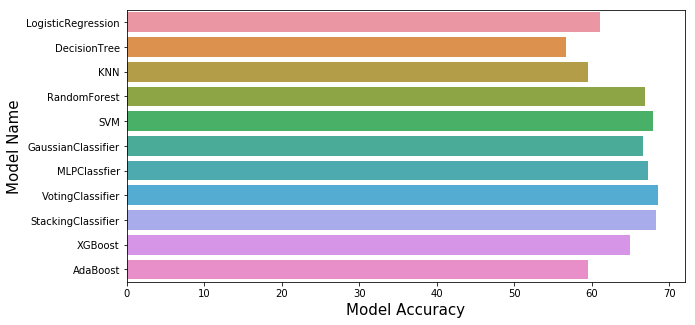

In [44]:
# Visualisation des accuracy
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Accuracy'], results['Model Name'])
plt.xlabel('Model Accuracy', fontsize=15)
plt.ylabel('Model Name', fontsize=15);

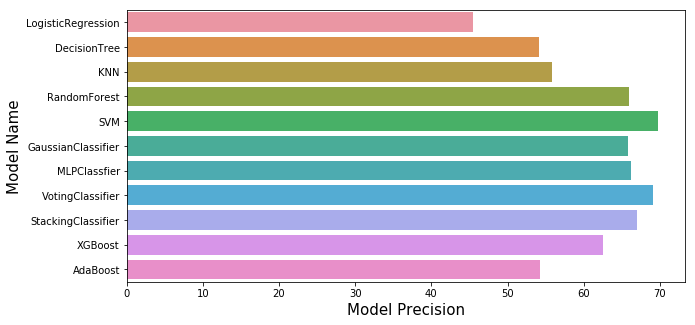

In [45]:
# Visualisation des precisions
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Precision'], results['Model Name'])
plt.xlabel('Model Precision', fontsize=15)
plt.ylabel('Model Name', fontsize=15);

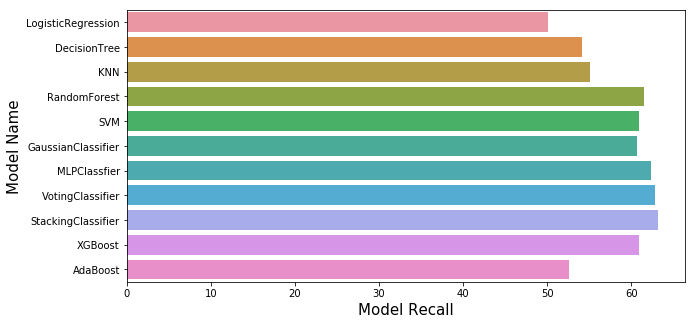

In [46]:
# Visualisation des rappels
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Recall'], results['Model Name'])
plt.xlabel('Model Recall', fontsize=15)
plt.ylabel('Model Name', fontsize=15);